## Flu ABM Env Experiment:
- k-vs-(N-k)
- Agents with High Network Degree
- Multi-Agent Actor-Critic/MADDPG

Multiplayer instance of Flu ABM with RL learners 

In [1]:
import itertools, importlib, sys, warnings, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML libs
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
# warnings.filterwarnings("ignore")

log_path = './log/flu'
#tensorboard --logdir=flugame_worker_1:'./log/train_rf_flugame_worker'

## suppress annoy verbose tf msgs
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # '3' to block all including error msgs
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Tensorflow version: 1.15.0


In [2]:
sys.path.append('./embodied_arch')
import embodied_arch.embodied_central_Qcritic as emac
importlib.reload(emac)

<module 'embodied_arch.embodied_central_Qcritic' from '/mnt/Lebesgue/Documents/Research/Coding/Python/rlabms/embodied_arch/embodied_central_Qcritic.py'>

In [3]:
import flumodel_python.flu_env_basic as FABM
import flumodel_python.flu_env as Fenv
from embodied_misc import ActionPolicyNetwork, ValueNetwork, SensoriumNetworkTemplate

## Sample ABM Popn by Degree

In [4]:
from flumodel_python.flu_env_base import get_connected_quartile_sample as popn_sample
# ?popn_sample

importlib.reload(FABM);
flu = FABM.Flu_ABM(model_path="./flumodel_python/")

0.24189526184538654 2231


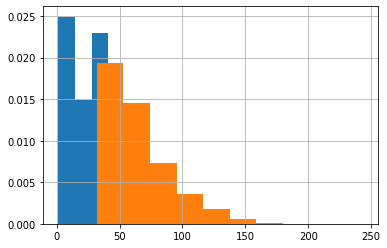

In [5]:
tmp = popn_sample(flu.popn, flu.nn_list, qt=4, n=2300)

print(np.mean(tmp.quartile_sample), sum(tmp.quartile_sample))
tmp[tmp.quartile_sample==0]['net.degree'].hist(density=True)
tmp[tmp.quartile_sample==1]['net.degree'].hist(density=True)

40

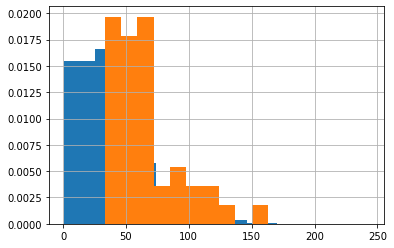

In [6]:
sz, samps = (0, 40)
while sz<samps:
    tmp = popn_sample(flu.popn, flu.nn_list, qt=4, n=samps)
    selector = (tmp.quartile_sample==1)
    sz = sum(selector)
agents = list(tmp[selector]['Person.ID'])[:samps]
exos_bool = list(flu.popn['Person.ID'].isin(agents))
exos = list(flu.popn.index[exos_bool])

tmp[tmp.quartile_sample==0]['net.degree'].hist(density=True)
tmp[tmp.quartile_sample==1]['net.degree'].hist(density=True)
len(exos)

## RL-Env Setup

In [7]:
importlib.reload(Fenv);
tf.reset_default_graph()
# exos = [1,2,3,10]  ## Now sampled by high degree distribution

flu_menv = Fenv.Flu_env(
    exo_idx=exos,
    model_path="./flumodel_python/"
)

40
8 1


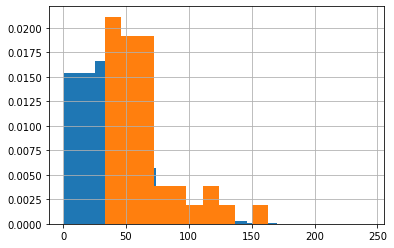

In [8]:
flu_menv.popn[[not b for b in exos_bool]]['net.degree'].hist(density=True)
flu_menv.popn[exos_bool]['net.degree'].hist(density=True)

print(flu_menv.actor_count)
print(flu_menv.state_space_size, flu_menv.action_space_size)

### MARL Setup Demo

In [9]:
actor = lambda s: ActionPolicyNetwork(s, hSeq=(8,), gamma_reg=1e-1)
value = lambda s: ValueNetwork(s, hSeq=(8,), gamma_reg=1.)
sensor = lambda st, out_dim: SensoriumNetworkTemplate(st, hSeq=(16,8,), out_dim=out_dim, gamma_reg=5.)

num_episodes, n_epochs, max_len = (100, 1501, 35)

In [10]:
importlib.reload(emac);
flumac = emac.EmbodiedAgent_MAC(
    name="flu_MAC_HiDeg", env_=flu_menv, 
    alpha_p=5e3, alpha_v=5e2, alpha_q=50,
    actorNN=actor, valueNN=value,
    sensorium=sensor,latentDim=4, 
    max_episode_length=max_len,
    _every_=300
)

In [11]:
sess = tf.InteractiveSession()
flumac.init_graph(sess) # note tboard log dir
saver = tf.train.Saver(max_to_keep=0) 

Tensorboard logs in:  ./log/train_flu_MAC_HiDeg


## Baseline

Baselining untrained pnet...
Episode 99/100
Agent is flu-free for an average of 94.50571428571429pct of seasons
Agent Action Correlations:


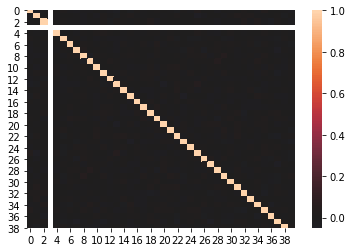

In [12]:
print('Baselining untrained pnet...')
rwds0 = []
acts_corr = np.zeros([flumac.actor_count,flumac.actor_count])
for k in range(num_episodes):
    flumac.play(sess, terminal_reward=0.);
    rwds0.append(flumac.last_total_returns)
    actions = np.array(flumac.episode_buffer['actions']).T
    acts_corr = acts_corr + (np.corrcoef(actions)/num_episodes)
    print("\rEpisode {}/{}".format(k, num_episodes),end="")

# Compute average rewards
base_perf = 100.*np.mean(np.array(rwds0)/float(flumac.max_episode_length))
base_per_agent = 100.*np.mean(np.array(rwds0)/float(flumac.max_episode_length), axis=0)

print("\nAgent is flu-free for an average of {}pct of seasons".format(
    1.*base_perf))
print("Agent Action Correlations:")
sns.heatmap(acts_corr, center=0)

## Train Agent Population

	Iteration 99: Value loss(12.8394193649292)6)

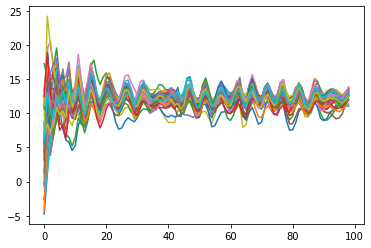

In [13]:
obs = []
for ct in range(100):
    flumac.play(sess)
    tmp = flumac.train_eval_QC(sess)
    obs.append(np.mean(tmp, axis=0))
    print('\r\tIteration {}: Value loss({})'.format(ct, np.mean(tmp)), end="")
plt.plot(obs[1:]);

In [14]:
# ### Train Agents
print('Training...')
flumac.work(sess, num_epochs=n_epochs, saver=saver)

Training...
Starting agent flu_MAC_HiDeg
Epoch no.: 0/1501

	Stats @Step 0: 	(Min, Mean, Max)
Perf/Recent Rewards: (27.0, 33.1, 35.0)
Losses/Policy LLs: (-2.20106, -0.5912465, -0.073469415)
Losses/Policy Entropies: (0.25579458, 0.5938948, 0.69305015)
Values/Critic Scores: (-3.7210548, -0.21051736, 3.3040764)
Values/Mean Q Scores: (15.843335, 19.427109, 21.8261)
Saved Model
Epoch no.: 300/1501

	Stats @Step 300: 	(Min, Mean, Max)
Perf/Recent Rewards: (30.0, 33.425, 35.0)
Losses/Policy LLs: (-2.3889627, -0.59307396, -0.003436102)
Losses/Policy Entropies: (0.022891432, 0.59207755, 0.6930134)
Values/Critic Scores: (-4.5094614, -0.5182001, 3.381241)
Values/Mean Q Scores: (20.289015, 24.328074, 25.995367)
Saved Model
Epoch no.: 600/1501

	Stats @Step 600: 	(Min, Mean, Max)
Perf/Recent Rewards: (29.0, 33.35, 35.0)
Losses/Policy LLs: (-3.136086, -0.54785234, -0.00036396665)
Losses/Policy Entropies: (0.0032448438, 0.5597362, 0.6931453)
Values/Critic Scores: (-7.3274965, -0.9248054, 3.26512)
Val

array([[27.   , 33.1  , 35.   ],
       [27.   , 32.85 , 35.   ],
       [27.   , 33.225, 35.   ],
       ...,
       [27.   , 33.75 , 35.   ],
       [28.   , 33.525, 35.   ],
       [30.   , 33.85 , 35.   ]])

## Test

Testing...
Episode 99/100
Agent is flu-free for an average of 95.87071428571429 pct compared to baseline of 94.50571428571429 pct
Agent Action Correlations:


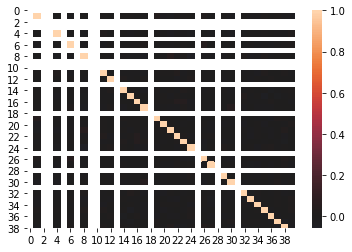

In [15]:
# Test pnet!
print('Testing...')
rwds = []
acts_corr_trained = np.zeros([flumac.actor_count,flumac.actor_count])
for k in range(num_episodes):
    flumac.play(sess)
    rwds.append(flumac.last_total_returns)
    actions = np.array(flumac.episode_buffer['actions']).T
    acts_corr_trained = acts_corr_trained + (np.corrcoef(actions)/num_episodes)
    print("\rEpisode {}/{}".format(k, num_episodes),end="")

trained_perf = 100.*np.mean(np.array(rwds)/float(flumac.max_episode_length))
trained_per_agent = 100.*np.mean(np.array(rwds)/float(flumac.max_episode_length), axis=0)

print("\nAgent is flu-free for an average of {} pct compared to baseline of {} pct".format(
    1.*trained_perf, 1.*base_perf) )
print("Agent Action Correlations:")
sns.heatmap(acts_corr_trained, center=0)

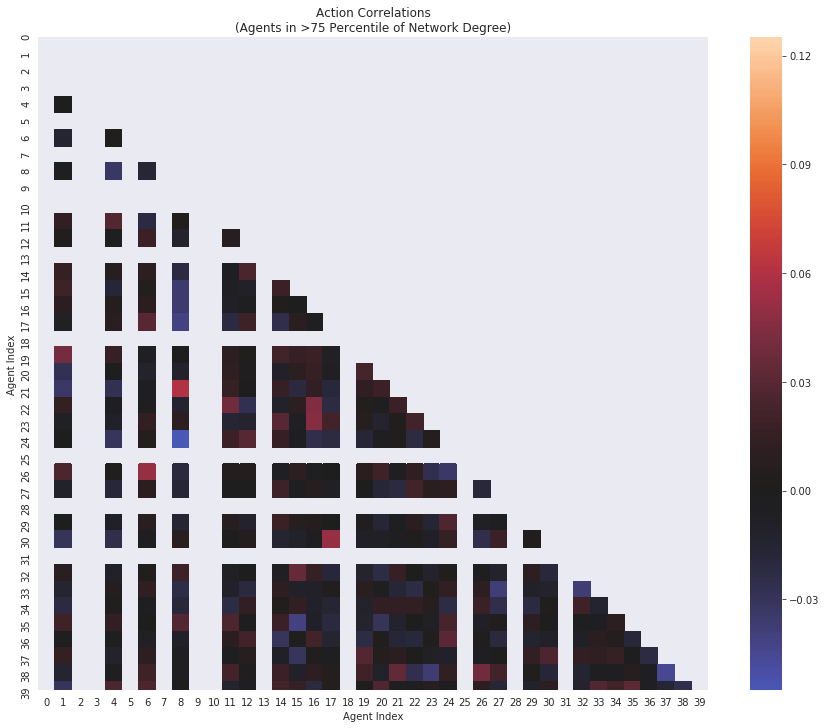

In [16]:
mask = np.zeros_like(acts_corr_trained)
mask[np.triu_indices_from(mask,k=0)] = True
with sns.axes_style("darkgrid"):
    plt.rcParams['figure.figsize'] = (15, 12)
    ax = sns.heatmap(acts_corr_trained, 
                     mask=mask, vmax=0.125, center=0)
    ax.set_ylabel("Agent Index")
    ax.set_xlabel("Agent Index")
    ax.set_title("Action Correlations\n(Agents in >75 Percentile of Network Degree)")

## Evaluate

In [17]:
rwds0_df = pd.DataFrame(100.*(np.array(rwds0)/float(flumac.max_episode_length)))
rwds_df = pd.DataFrame(100.*(np.array(rwds)/float(flumac.max_episode_length)))

rwds0_df['Wave'] = "Baseline"
rwds_df['Wave'] = "Trained"

resDF = pd.concat([rwds0_df, rwds_df])
resDF.columns = ["Agent"+str(tc) if tc is not "Wave" else tc for tc in resDF.columns]
# resDF['id'] = resDF.index
print(resDF.shape)
# resDF.head()

(200, 41)


In [18]:
resDF = resDF.melt(
    id_vars=['Wave'], #['id', 'Wave'],
    value_vars=[tc for tc in resDF.columns if "Agent" in tc]
)
resDF = resDF.rename(columns={"variable": "Agent", "value": "Immune_pct"})
print(resDF.shape)

res_tabs = resDF.groupby(['Agent','Wave']).aggregate(['mean','std']) # res_tabs

# resDF.head()

(8000, 3)


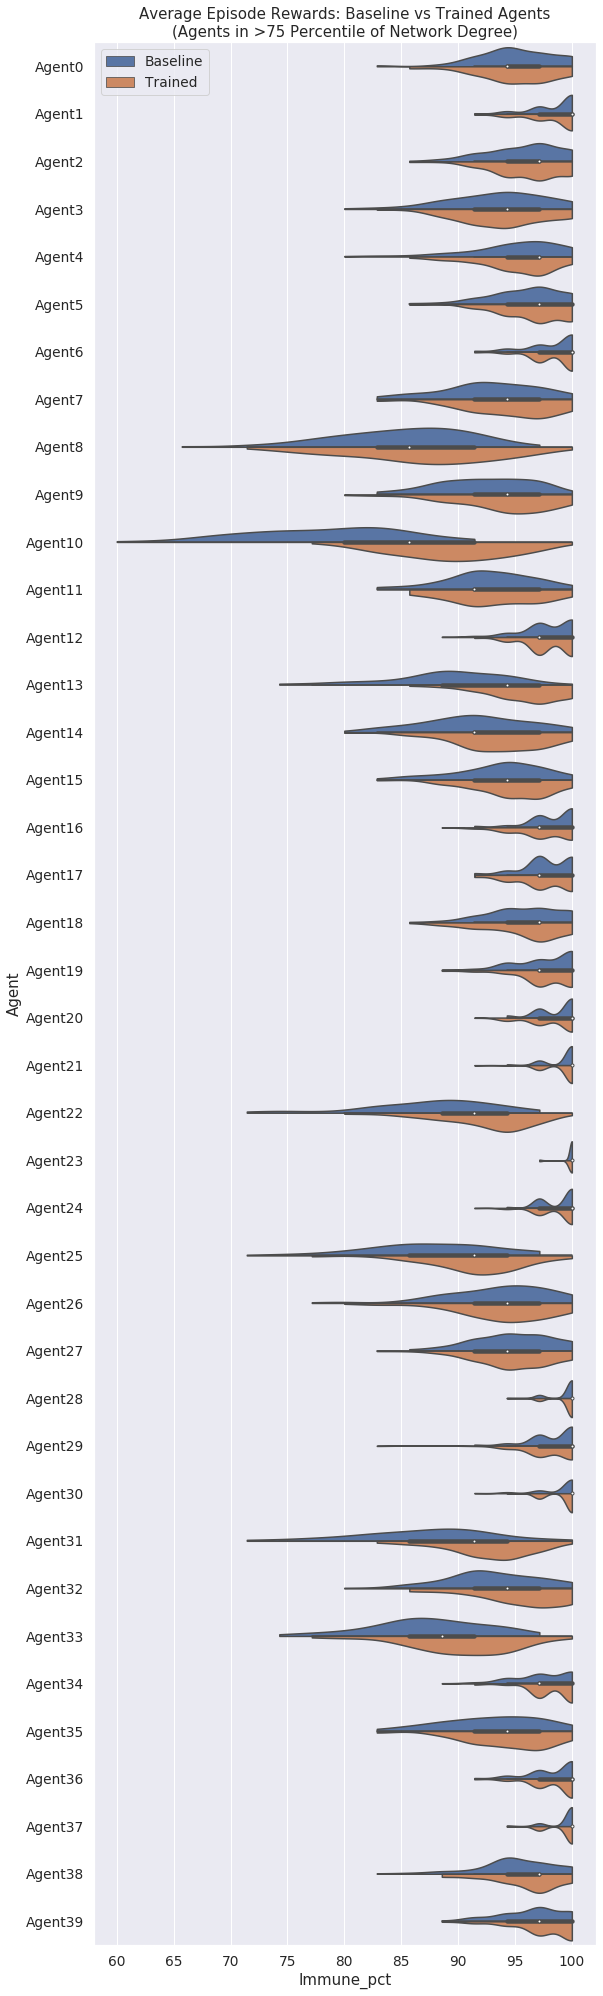

In [19]:
plt.rcParams['figure.figsize'] = (9, 35)
sns.set(font_scale=1.25)

fig = sns.violinplot(data=resDF, inner="box", cut=0,
                     x="Immune_pct", y="Agent", hue="Wave",
                     split=True);# fig.set_xticklabels(fig.get_xticklabels(), rotation=45);
fig.set_title('Average Episode Rewards: Baseline vs Trained Agents\n(Agents in >75 Percentile of Network Degree)');
fig.legend(loc='upper left');

In [20]:
base_meanDF = resDF[resDF.Wave=="Baseline"].groupby(['Agent']).aggregate(['mean'])
base_meanDF.sort_index(inplace=True)

trained_meanDF = resDF[resDF.Wave=="Trained"].groupby(['Agent']).aggregate(['mean'])
trained_meanDF.sort_index(inplace=True)

mean_diffDF = (trained_meanDF - base_meanDF)
mean_diffDF.columns = ['Mean_Immune_Pct_Change']
# mean_diffDF.head()

In [24]:
(mean_diffDF.mean().values, mean_diffDF.std().values)

(array([1.365]), array([2.34332603]))

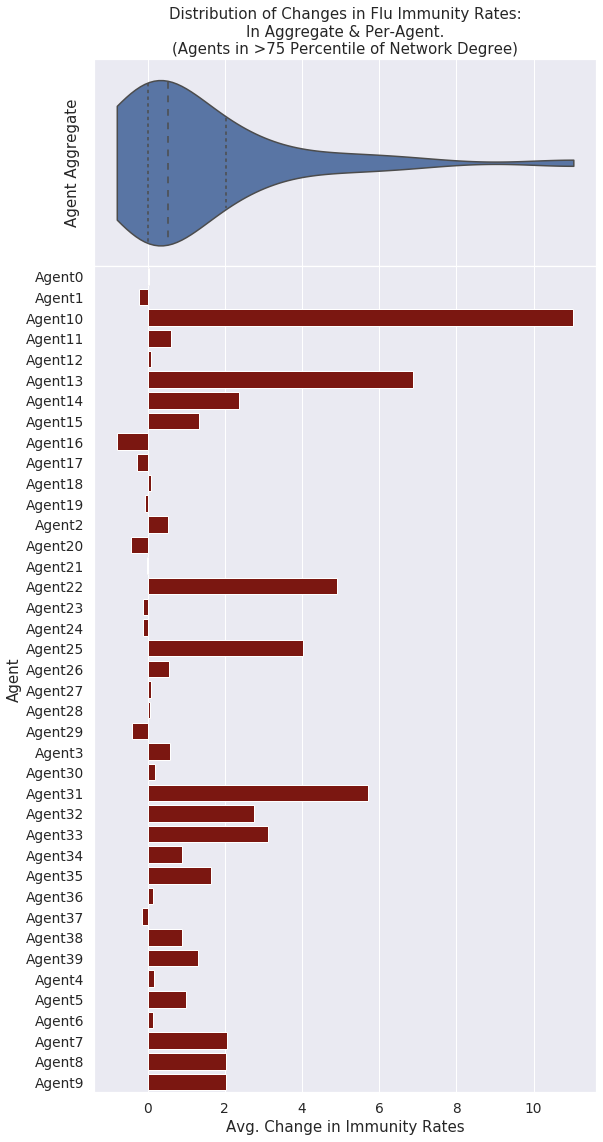

In [21]:
plt.rcParams['figure.figsize'] = (9, 19)
sns.set_color_codes("dark")
fig, axs = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [1,4]})
cmp = sns.violinplot(x='Mean_Immune_Pct_Change', cut=0, inner='quartile',
                     data=mean_diffDF, ax=axs[0])
axs[0].set_ylabel('Agent Aggregate');
axs[0].set_title(
    'Distribution of Changes in Flu Immunity Rates:\nIn Aggregate & Per-Agent.\n(Agents in >75 Percentile of Network Degree)'
);

sns.barplot(y=mean_diffDF.index, x="Mean_Immune_Pct_Change", 
            data=mean_diffDF, color="r",
            label="Success Rate", ax=axs[1]);
plt.subplots_adjust(wspace=0, hspace=0)
axs[1].set_xlabel('Avg. Change in Immunity Rates');